### Hand Tracking

MediaPipe and OpenAI Gym for a cart pole that is controlled from hand position in the webcam. See [Hand Tracking](https://apmonitor.com/pds/index.php/Main/HandTracking) in [Machine Learning for Engineers](https://apmonitor.com/pds).

<img width=500px align=left src='https://apmonitor.com/pds/uploads/Main/hand_tracking.png'>

In [1]:
pip install opencv-python mediapipe pyglet pygame gymnasium

/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Handedness: [classification {
  index: 1
  score: 0.926445186
  label: "Right"
}
, classification {
  index: 1
  score: 0.990786731
  label: "Right"
}
]
hand_landmarks: landmark {
  x: 0.787074685
  y: 0.813382
  z: 6.4213782e-07
}
landmark {
  x: 0.69010371
  y: 0.760793
  z: -0.044777222
}
landmark {
  x: 0.610196948
  y: 0.664209306
  z: -0.0683910251
}
landmark {
  x: 0.563714504
  y: 0.563397229
  z: -0.0876482427
}
landmark {
  x: 0.564713359
  y: 0.470904946
  z: -0.104238249
}
landmark {
  x: 0.698380351
  y: 0.452177435
  z: -0.0289654639
}
landmark {
  x: 0.683691561
  y: 0.300637305
  z: -0.0564509891
}
landmark {
  x: 0.678379416
  y: 0.209527448
  z: -0.0817186162
}
landmark {
  x: 0.678207636
  y: 0.129674107
  z: -0.100855
}
landmark {
  x: 0.75711596
  y: 0.436175764
  z: -0.0289212279
}
landmark {
  x: 0.755049944
  y: 0.271160483
  z: -0.0489133783
}
landmark {
  x: 0.757643402
  y: 0.167575032
  z: -0.0674847737
}
landmark {
  x: 0.761095047
  y: 0.0818094611
  z: -0

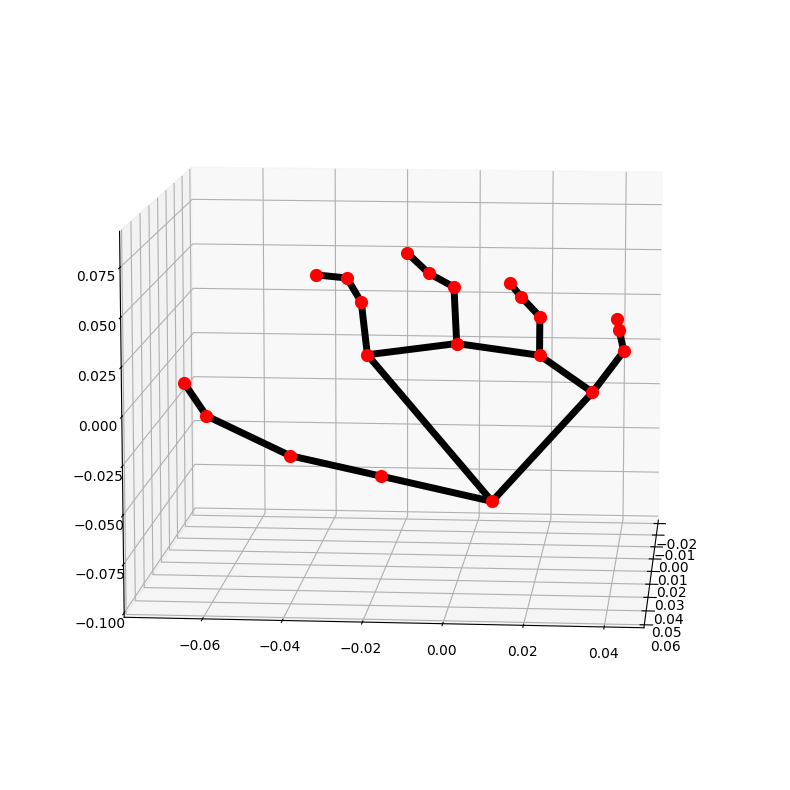

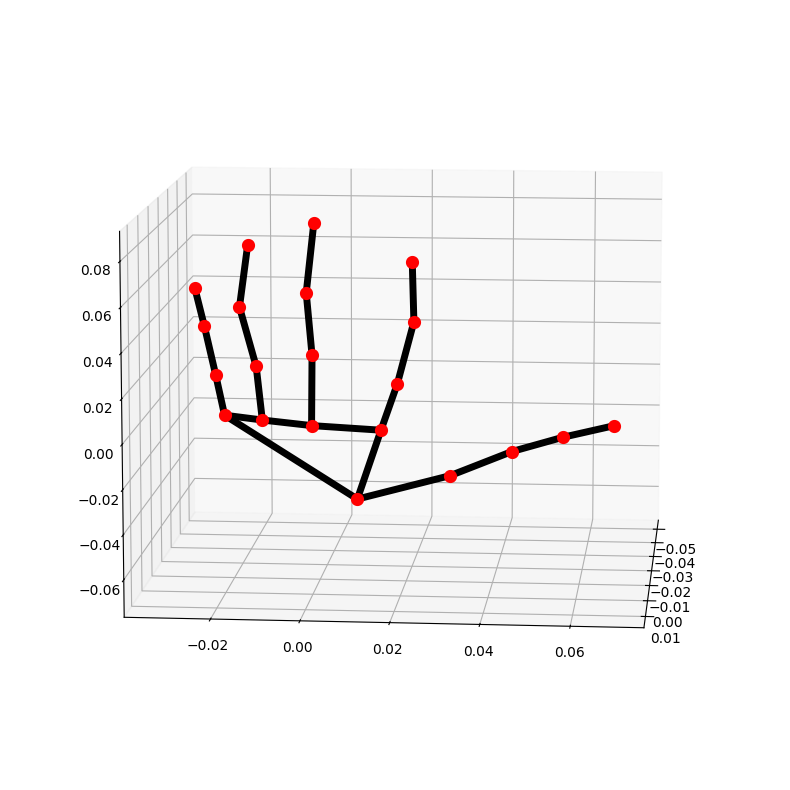

In [2]:
# https://google.github.io/mediapipe/solutions/hands
import cv2
import mediapipe as mp
import os
import urllib.request

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# download image as hands.jpg
url = 'http://apmonitor.com/pds/uploads/Main/hands.jpg'
urllib.request.urlretrieve(url, 'hands.jpg')
IMAGE_FILES = ['hands.jpg']
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.flip(cv2.imread(file), 1)

    # Convert the BGR image to RGB before processing.
    results = hands.process(cv2.cvtColor(image, \
                            cv2.COLOR_BGR2RGB))

    # Print handedness and draw hand landmarks on the image.
    print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      continue
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    for hand_landmarks in results.multi_hand_landmarks:
      tip = mp_hands.HandLandmark.INDEX_FINGER_TIP
      print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[tip].x * image_width}, '
          f'{hand_landmarks.landmark[tip].y * image_height})'
      )
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    cv2.imwrite('annotated_image' + str(idx) + '.png', \
                cv2.flip(annotated_image, 1))
    # Draw hand world landmarks.
    if not results.multi_hand_world_landmarks:
      continue
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      mp_drawing.plot_landmarks(
        hand_world_landmarks, \
        mp_hands.HAND_CONNECTIONS, azimuth=5)

<img width=400px align=left src='http://apmonitor.com/pds/uploads/Main/cartpole.gif'>

In [3]:
import gymnasium as gym
env = gym.make("CartPole-v1",render_mode='human')
observation = env.reset()
for _ in range(100):
  env.render()
  # Input:
  #   Force to the cart with actions: 0=left, 1=right
  # Returns:
  #   obs = cart position, cart velocity, pole angle, rot rate
  #   reward = +1 for every timestep
  #   done = True when abs(angle)>15 or abs(cart pos)>2.4
  action = env.action_space.sample() # random action
  observation, reward, done, info, e = env.step(action)

  if done:
    observation = env.reset()
env.close()

<img align=left width=500px src='https://apmonitor.com/pds/uploads/Main/hand_cart.png'>

### Hand Tracking with Webcam in Colab

To access the webcam in Google Colab, we need to use a combination of Python and JavaScript. The following cells will:
1. Set up a utility to capture frames from your webcam.
2. Integrate the MediaPipe hand tracking logic with the captured frames.
3. Display the live feed with hand landmarks in the notebook output.

In [4]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js, register_callback
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import cv2
import mediapipe as mp

# JavaScript to take a photo from the webcam
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the display
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Function to convert base64 string to OpenCV image
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

# JavaScript to continuously capture frames (this is a Python function that injects JS)
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function startStream() {
      labelElement = document.createElement('div');
      labelElement.innerHTML = 'Status: Ready to stream';
      document.body.appendChild(labelElement);

      div = document.createElement('div');
      video = document.createElement('video');
      video.style.display = 'block';
      document.body.appendChild(div);
      div.appendChild(video);

      stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the display.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = video.videoWidth;
      captureCanvas.height = video.videoHeight;
      captureCanvas.getContext('2d').drawImage(video, 0, 0);
      imgElement = document.createElement('img');
      imgElement.src = 'data:image/jpeg;base64,' + b64encode(new Uint8Array(0));
      div.appendChild(imgElement);

      labelElement.innerHTML = 'Status: Streaming...';
      requestAnimationFrame(sendFrame);
    }

    function stopStream() {
      shutdown = true;
      if (stream) {
        stream.getVideoTracks()[0].stop();
      }
      if (div) {
        div.remove();
      }
      if (labelElement) {
        labelElement.remove();
      }
    }

    function sendFrame() {
      if (shutdown) {
        return;
      }

      captureCanvas.getContext('2d').drawImage(video, 0, 0);
      var dataURL = captureCanvas.toDataURL('image/jpeg', 0.8);
      imgElement.src = dataURL;
      google.colab.kernel.invokeFunction('notebookOutput', [dataURL]);

      requestAnimationFrame(sendFrame);
    }

    startStream(); // Add this line to immediately start the stream when JS is injected
    ''')
  display(js)

def video_frame(func):
  def wrapper(*args, **kwargs):
    encode = b64encode(cv2.imencode('.jpg', func(*args, **kwargs))[1]).decode('utf-8')
    display(Javascript('imgElement.src = "data:image/jpeg;base64,{}"'.format(encode)))
  return wrapper

# Initialize MediaPipe Hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# Setup MediaPipe Hands model
hands = mp_hands.Hands(model_complexity=0, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Register Python function to receive JavaScript frames
def notebook_output(data_url_origin):
  # Decode base64 to image
  image = js_to_image(data_url_origin)

  # Process image for hand tracking
  image.flags.writeable = False
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  results = hands.process(image)

  # Draw the hand annotations on the image.
  image.flags.writeable = True
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
      mp_drawing.draw_landmarks(
          image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())

  # Flip image horizontally for selfie-view display.
  image = cv2.flip(image, 1)

  # Convert the image to base64 for display in JS
  _, jpeg_img = cv2.imencode('.jpg', image)
  jpeg_b64 = b64encode(jpeg_img.tobytes()).decode('utf-8')
  display(Javascript(f'imgElement.src = "data:image/jpeg;base64,{jpeg_b64}"'))

  # Placeholder for cartpole interaction (if needed later)
  # if results.multi_hand_landmarks:
  #   for hand_landmarks in results.multi_hand_landmarks:
  #     h, w, _ = image.shape
  #     t = mp_hands.HandLandmark.INDEX_FINGER_TIP
  #     x = hand_landmarks.landmark[t].x
  #     # Implement cartpole action based on x
  #     # print(f'Index finger tip x-coordinate: {x}')

# Register the Python function `notebook_output` to be called from JavaScript.
# This allows JavaScript to send frames to Python for processing.


In [5]:
register_callback('notebookOutput', notebook_output)

# Start the video stream from JavaScript
video_stream()

<IPython.core.display.Javascript object>

### Stopping the Webcam Stream

To stop the webcam stream, you need to execute the following JavaScript function. You can run this cell when you are done with hand tracking.

Alternatively, you can click `Runtime -> Interrupt execution` from the Colab menu.

In [6]:
from google.colab.output import eval_js

js_code = Javascript('''
  if (typeof stopStream === 'function') {
    stopStream();
  }
''')
display(js_code)

<IPython.core.display.Javascript object>

In [7]:
# may not work in Jupyter Notebook
# run as a script from the terminal
import cv2
import mediapipe as mp
import os
import gymnasium as gym
import random
import warnings
import time

env = gym.make("CartPole-v1",render_mode='rgb_array')
observation = env.reset()
warnings.filterwarnings("ignore", category=UserWarning)

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# Webcam input
error_count = 0
cap = cv2.VideoCapture(0)
with mp_hands.Hands(model_complexity=0,min_detection_confidence=0.5,
                    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if image is None:
      time.sleep(0.1)
      error_count += 1
      if error_count<100:
        continue
      else:
        print('Error reading from webcam')
        break
    else:
      error_count = 0
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    hand_landmarks = None
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    image2 = cv2.flip(image, 1)
    # Resize image
    width = 800
    height = int(image.shape[0]*(width/image2.shape[1]))
    dim = (width,height)
    image2 = cv2.resize(image2, dim)

    if hand_landmarks:
      h, w, _ = image.shape
      t = mp_hands.HandLandmark.INDEX_FINGER_TIP
      x = hand_landmarks.landmark[t].x
      y = hand_landmarks.landmark[t].y
    else:
      x = 0.5

    cart = env.render()
    # take bottom 2/3 of image
    cart = cart[int(cart.shape[0]/3):]
    height = int(cart.shape[0] * (image2.shape[1]/cart.shape[1]))
    dim = (image2.shape[1], height)
    cart = cv2.resize(cart, dim)
    image3 = cv2.vconcat([cart,image2])
    cv2.imshow('Hands - CartPole', image3)
    if cv2.waitKey(5) & 0xFF == 27:
      break

    r = random.random()
    if x<0.3:
      action = 1
    elif x>0.7:
      action = 0
    else:
      if r>=x:
        action = 1
      else:
        action = 0
    observation, reward, done, info, e = env.step(action)

    if abs(observation[0])>3:
      observation = env.reset()

env.close()
cap.release()